### В этом ноутбуке можно проверить свою фотографию по любому из двух векторов: является она рестораном или нет, какая у неё атмосфера, а заодно - отследить все этапы работы алгоритма :)

## 1. Загрузка фотографии

In [1]:
from PIL import Image

In [2]:
img_path = 'example_photos/restaurant.jpg'

In [3]:
image = Image.open(img_path)

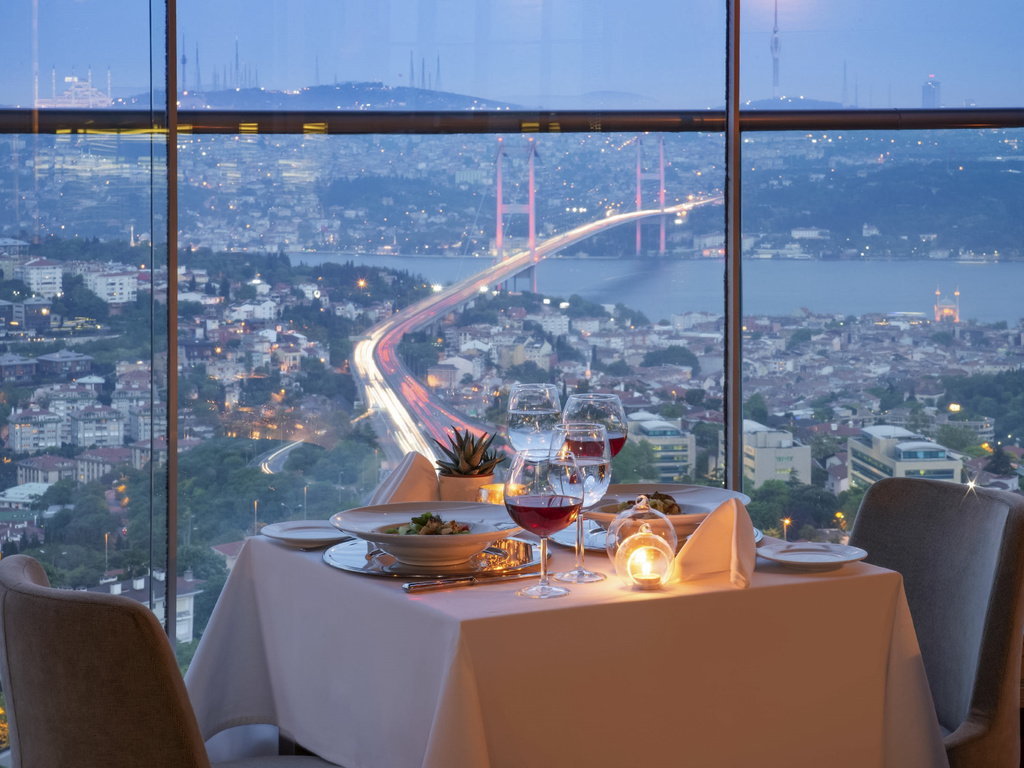

In [4]:
image

## 2. Векторизация предобученной DenseNet

In [5]:
import torch
import torchvision
from torchvision import models, transforms
from imports.lightning_model import load_model

In [6]:
dense_net, _ = load_model(model_name='densenet',
                          output_dim=2,
                          feature_extract=True,
                          use_pretrained=True,
                          do_vectorize=True)

In [7]:
feature_transforms = transforms.Compose([
                     transforms.Resize(224),
                     transforms.CenterCrop(224),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
img_transformed = feature_transforms(image).unsqueeze(0)

In [9]:
trf_vector = dense_net(img_transformed).numpy()

In [10]:
trf_vector

array([[3.4574696e-04, 4.3108277e-03, 3.0575665e-03, ..., 1.4757946e+00,
        1.0996293e+00, 1.1608993e+00]], dtype=float32)

## 3. Извлечение объектов

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
detection_model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    pretrained=True, progress=True, num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None)

In [13]:
detection_model.to(device).eval()
print(1)

1


In [14]:
def get_prediction(model, image, threshold):
    
    preds = model(image)[0]
    
    keep_boxes = torchvision.ops.nms(preds['boxes'], preds['scores'], 0.5)
    
    classes = list(preds['labels'].cpu().numpy())
    classes = [classes[idx] for idx in keep_boxes]
    boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(preds['boxes'].cpu().detach().numpy())]
    boxes = [boxes[idx] for idx in keep_boxes]
    scores = list(preds['scores'].cpu().detach().numpy())
    scores = [scores[idx] for idx in keep_boxes]
    
    valid_boxes = [scores.index(x) for x in scores if x>threshold]
    if not valid_boxes: return [()]
    p_thresh = valid_boxes[-1]
    pred_boxes = boxes[:p_thresh+1]
    pred_classes = classes[:p_thresh+1]
    pred_scores = scores[:p_thresh+1]
    
    return list(zip(pred_boxes, pred_classes, pred_scores))

In [15]:
obj_transforms = transforms.Compose([transforms.ToTensor()])

In [16]:
img_transformed = obj_transforms(image).unsqueeze(0).to(device)

In [17]:
detected_objects = get_prediction(detection_model, img_transformed, 0.5)

### 3.1. Демонстрация извлечённых объектов

In [18]:
from PIL import ImageDraw, ImageFont

In [19]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [20]:
def draw_boxes(img, predictions, font_color='white', threshold=0.5):
    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)
    for obj in predictions:
        if obj:
            box, label, score = obj
            label = COCO_INSTANCE_CATEGORY_NAMES[label]
            draw.rectangle(box, width=2)
            x1,y1 = box[0]
            x2,y2 = box[1]
            x=(x1+x2)//2
            y=(y1+y2)//2
            draw.text((x,y), label, fill=font_color)
    return img_copy

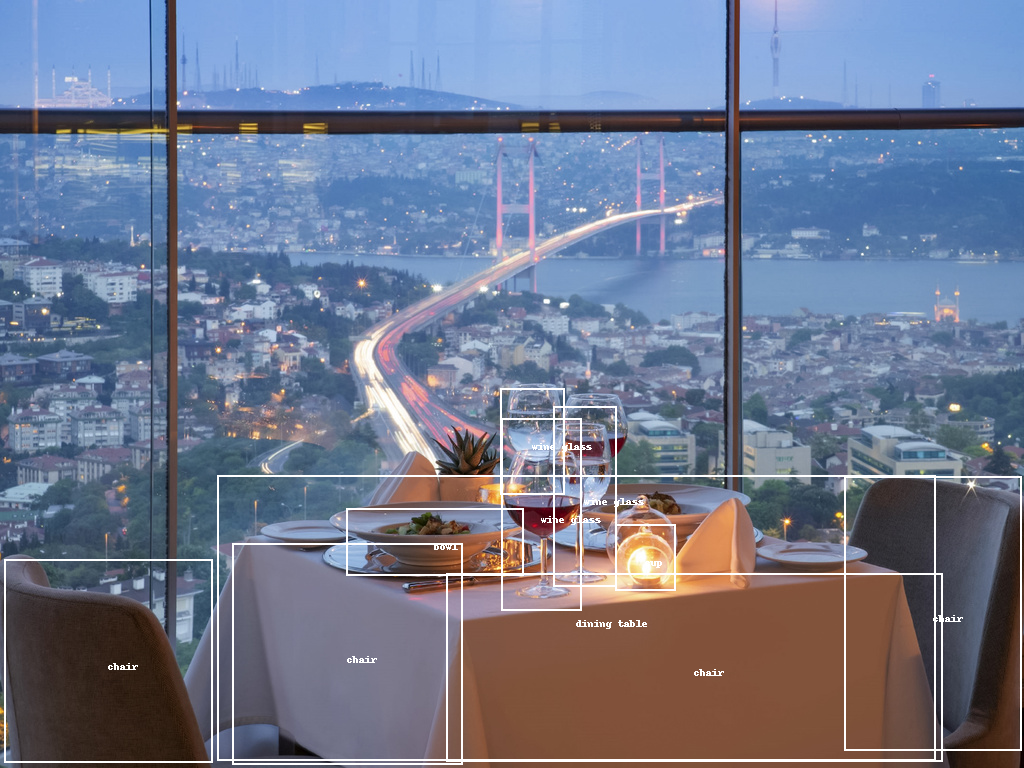

In [21]:
draw_boxes(image, detected_objects)

## 4. Формирование итогового feature вектора

In [22]:
import numpy as np

In [23]:
detected_objects

[([(4.551734, 559.1478), (212.40294, 762.982)], 62, 0.9945834),
 ([(501.8923, 418.70908), (581.60913, 610.96344)], 46, 0.9943463),
 ([(553.4072, 406.2935), (616.5237, 586.5954)], 46, 0.976319),
 ([(844.7309, 476.53687), (1021.9777, 750.9541)], 62, 0.9634248),
 ([(217.3154, 475.91336), (935.13086, 760.2242)], 67, 0.924053),
 ([(232.44131, 543.9341), (462.37964, 764.8724)], 62, 0.8916105),
 ([(615.51117, 524.36255), (675.5546, 590.481)], 47, 0.8354039),
 ([(446.64575, 573.219), (942.22845, 761.7445)], 62, 0.78367877),
 ([(346.5361, 508.24844), (523.34296, 575.3977)], 51, 0.66391534),
 ([(500.96536, 388.6975), (564.09326, 494.19168)], 46, 0.557119)]

In [24]:
vector_size = len(COCO_INSTANCE_CATEGORY_NAMES)
vector_size

91

In [25]:
confidence_vector = np.zeros(vector_size)
counts_vector = np.zeros(vector_size)

In [26]:
for box in detected_objects:
    if box:
        _, idx, confidence = box
        confidence_vector[idx] = max(confidence_vector[idx], confidence)
        counts_vector[idx] += 1

In [27]:
obj_vector = np.concatenate((confidence_vector, counts_vector))

In [28]:
obj_vector = obj_vector.reshape((1, obj_vector.shape[0]))

In [29]:
obj_vector.shape

(1, 182)

Следующие позиции в обучающей выборке были нулевые у всех векторов, так что при предобработке они исключаются для уменьшения размерности:

In [30]:
empty_columns = [0, 12, 26, 29, 30, 45, 66, 68, 69, 71, 83, 91, 103, 117, 120, 121, 136, 157, 159, 160, 162, 174]

In [31]:
for c in empty_columns[::-1]:
    obj_vector = np.delete(obj_vector, c, 1)

In [32]:
obj_vector.shape

(1, 160)

In [33]:
feature_vector = np.concatenate((trf_vector, obj_vector), axis=1)

In [34]:
feature_vector.shape

(1, 1184)

Верная результирующая размерность, ура!

## 5. Предсказание

In [35]:
import pickle

In [36]:
br_model_path = 'pretrained_models/br_lr.sav'
amb_model_path = 'pretrained_models/amb_lr.sav'

In [37]:
with open(br_model_path, 'rb') as br:
    br_model = pickle.load(br)

In [38]:
with open(amb_model_path, 'rb') as amb:
    amb_model = pickle.load(amb)

Шаг нормализации заложен в модель:

In [39]:
br_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, random_state=42))])

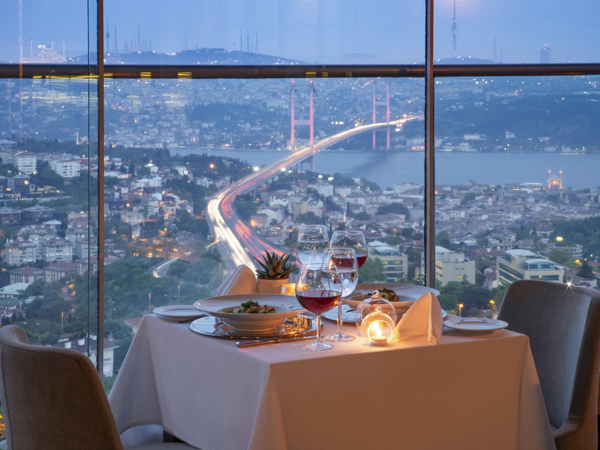

In [40]:
image.thumbnail((600,600))
image

In [41]:
is_business = br_model.predict(feature_vector)
print('Is not a restaurant!') if is_business else print('Is a restaurant!')

Is a restaurant!


In [42]:
amb_mapping = ['touristy', 'hipster', 'romantic', 'divey', 'intimate', 'upscale']

In [43]:
amb_pred = amb_model.predict(feature_vector)[0]
ambience = [amb_mapping[i] for i in range(len(amb_pred)) if amb_pred[i]]

In [44]:
ambience

['romantic', 'intimate']